# Imports

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, KFold

In [2]:
import sys
import os

project_root = os.path.abspath("..")   # one level up from notebooks/
sys.path.append(project_root)

from models.custom_regression_tree import CustomRegressionTree

# Global variables

In [3]:
DATA_PATH = "../data"

RANDOM_STATE = 42

LABEL_COL = "Paddy yield(in Kg)"

# Functions

In [58]:
def get_scores(reals: np.array, preds: np.array) -> dict:
    rmse = np.sqrt(np.mean((preds - reals)**2))
    mape = np.mean(np.abs((reals - preds) / reals)) * 100

    return {"RMSE": rmse, "MAPE": mape}

def generate_cv_summary(model_scores: dict, metric: str = "RMSE") -> None:
    num_models = len(model_scores.keys())
    fig, ax = plt.subplots(1, num_models, figsize=(20,5))
    if num_models == 1:
        ax = [ax]

    min_metric, max_metric = None, None

    all_metrics = [metric_val for model in model_scores.values() for metric_val in model[metric]]
    min_metric, max_metric = np.min(all_metrics), np.max(all_metrics)

    summaries = []
    
    for i, items in enumerate(model_scores.items()):
        k, v = items

        sns.boxplot(v[metric], ax=ax[i])
        ax[i].set_ylim(min_metric*0.9, max_metric*1.1)
        ax[i].set_xlabel(k.replace("@", "\n"))

        summary = {"MODEL": k, "METRIC": metric, "MIN": np.min(v[metric]), "MAX": np.max(v[metric]), "MEAN": np.mean(v[metric]), "STD_DEV": np.std(v[metric])}
        summaries.append(summary)
    display(pd.DataFrame(summaries))
    fig.suptitle("Cross-validation for model parameters", fontsize=16)
    plt.tight_layout()

# Data ingestion

In [5]:
df_paddies = pd.read_csv(f"{DATA_PATH}/RicePaddy/paddydataset.csv")
df_paddies

,Hectares,Agriblock,Variety,Soil Types,Seedrate(in Kg),LP_Mainfield(in Tonnes),Nursery,Nursery area (Cents),LP_nurseryarea(in Tonnes),DAP_20days,...,Wind Direction_D1_D30,Wind Direction_D31_D60,Wind Direction_D61_D90,Wind Direction_D91_D120,Relative Humidity_D1_D30,Relative Humidity_D31_D60,Relative Humidity_D61_D90,Relative Humidity_D91_D120,Trash(in bundles),Paddy yield(in Kg)
0,6,Cuddalore,CO_43,alluvial,150,75.0,dry,120,6,240,...,SW,W,NNW,WSW,72.0,78,88,85,540,35028
1,6,Kurinjipadi,ponmani,clay,150,75.0,wet,120,6,240,...,NW,S,SE,SSE,64.6,85,84,87,600,35412
2,6,Panruti,delux ponni,alluvial,150,75.0,dry,120,6,240,...,ENE,NE,NNE,W,85.0,96,84,79,600,36300
3,6,Kallakurichi,CO_43,clay,150,75.0,wet,120,6,240,...,W,WNW,SE,S,88.5,95,81,84,540,35016
4,6,Sankarapuram,ponmani,alluvial,150,75.0,dry,120,6,240,...,SSE,W,SW,NW,72.7,91,83,81,600,34044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2784,1,Kallakurichi,CO_43,alluvial,25,12.5,wet,20,1,40,...,W,WNW,SE,S,88.5,95,81,84,90,5836
2785,1,Sankarapuram,ponmani,clay,25,12.5,wet,20,1,40,...,SSE,W,SW,NW,72.7,91,83,81,100,5723
2786,1,Chinnasalem,delux ponni,clay,25,12.5,wet,20,1,40,...,E,ENE,NE,NNW,78.6,80,92,88,80,5723
2787,1,Cuddalore,CO_43,alluvial,25,12.5,wet,20,1,40,...,SW,W,NNW,WSW,72.0,78,88,85,90,5916


<Axes: ylabel='Paddy yield(in Kg)'>

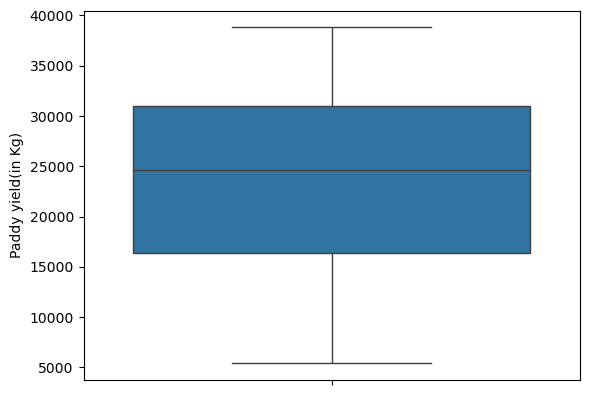

In [6]:
sns.boxplot(df_paddies[LABEL_COL])

In [7]:
df_train, df_test = train_test_split(df_paddies, train_size=0.7, shuffle=True, random_state=RANDOM_STATE)
df_train.shape, df_test.shape

((1952, 45), (837, 45))

In [45]:
kf = KFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)

cust_reg_tree_param_grid = [
    {"max_depth":3, "min_samples_split":2},
    {"max_depth":4, "min_samples_split":2},
    {"max_depth":8, "min_samples_split":2},
    {"max_depth":16, "min_samples_split":2},
    {"max_depth":32, "min_samples_split":2},
    {"max_depth":64, "min_samples_split":2},

    # {"max_depth":2, "min_samples_split":4},
    # {"max_depth":4, "min_samples_split":4},
    # {"max_depth":8, "min_samples_split":4},
    # {"max_depth":16, "min_samples_split":4},
    # {"max_depth":32, "min_samples_split":4},
    # {"max_depth":64, "min_samples_split":4},
]

feat_cols = [col for col in df_train if col != LABEL_COL]

numeric_features = df_train[feat_cols].select_dtypes(include=["number"]).columns.tolist()
categorical_features = [c for c in feat_cols if c not in numeric_features]

model_scores = {}

for train_idx, test_idx in kf.split(df_train):
    X_train_raw = df_train.iloc[train_idx][feat_cols]
    X_test_raw  = df_train.iloc[test_idx][feat_cols]

    y = df_train[LABEL_COL].values
    y_train, y_test = y[train_idx], y[test_idx]
    
    # Preprocessing: scale numeric, one-hot encode categorical
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), numeric_features),
            ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_features),
        ]
    )

    # Fit on train fold, transform both train and test
    X_train = preprocessor.fit_transform(X_train_raw)
    X_test = preprocessor.transform(X_test_raw)

    # Cross-validate Custom Regression Tree model
    for cust_reg_tree_params in cust_reg_tree_param_grid:
        model_name = "CUSTOM_REGRESSION_TREE@" + str(cust_reg_tree_params).replace(":", "=").replace(" ", "").replace("'", "")
        if model_name not in model_scores.keys():
            model_scores[model_name] = {"RMSE": [], "MAPE": []}

        custom_reg_tree_model = CustomRegressionTree(**cust_reg_tree_params)
        custom_reg_tree_model.fit(X_train, y_train)
    
        custom_reg_tree_preds = custom_reg_tree_model.predict(X_test)
        
        custom_reg_tree_metrics = get_scores(reals=y_test, preds=custom_reg_tree_preds)
        model_scores[model_name]["RMSE"].append(custom_reg_tree_metrics["RMSE"])
        model_scores[model_name]["MAPE"].append(custom_reg_tree_metrics["MAPE"])

    # Cross-validate Sklearn Regression Tree model
    # TO DO: Implement

,MODEL,METRIC,MIN,MAX,MEAN,STD_DEV
0,"CUSTOM_REGRESSION_TREE@{max_depth=3,min_sample...",RMSE,707.704956,896.156957,841.310011,52.685695
1,"CUSTOM_REGRESSION_TREE@{max_depth=4,min_sample...",RMSE,666.422410,876.568351,812.650706,55.201294
2,"CUSTOM_REGRESSION_TREE@{max_depth=8,min_sample...",RMSE,715.101594,978.291728,858.052483,72.696496
3,"CUSTOM_REGRESSION_TREE@{max_depth=16,min_sampl...",RMSE,743.202155,1011.936801,885.222188,78.975483
4,"CUSTOM_REGRESSION_TREE@{max_depth=32,min_sampl...",RMSE,743.202155,1011.936801,885.222188,78.975483
5,"CUSTOM_REGRESSION_TREE@{max_depth=64,min_sampl...",RMSE,743.202155,1011.936801,885.222188,78.975483


,MODEL,METRIC,MIN,MAX,MEAN,STD_DEV
0,"CUSTOM_REGRESSION_TREE@{max_depth=3,min_sample...",MAPE,2.238751,2.850156,2.595844,0.155101
1,"CUSTOM_REGRESSION_TREE@{max_depth=4,min_sample...",MAPE,2.236840,2.801778,2.565467,0.150981
2,"CUSTOM_REGRESSION_TREE@{max_depth=8,min_sample...",MAPE,2.363349,3.079422,2.701748,0.198848
3,"CUSTOM_REGRESSION_TREE@{max_depth=16,min_sampl...",MAPE,2.421675,3.138062,2.793739,0.208603
4,"CUSTOM_REGRESSION_TREE@{max_depth=32,min_sampl...",MAPE,2.421675,3.138062,2.793739,0.208603
5,"CUSTOM_REGRESSION_TREE@{max_depth=64,min_sampl...",MAPE,2.421675,3.138062,2.793739,0.208603


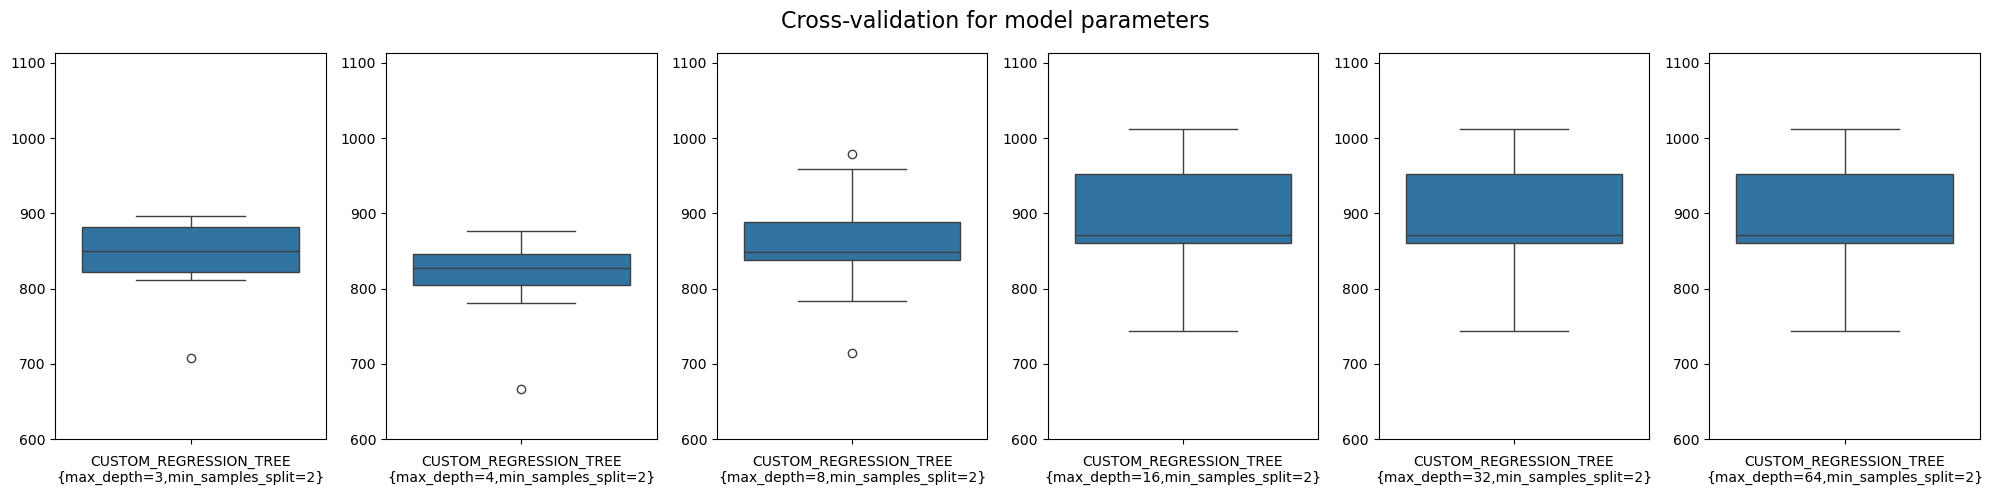

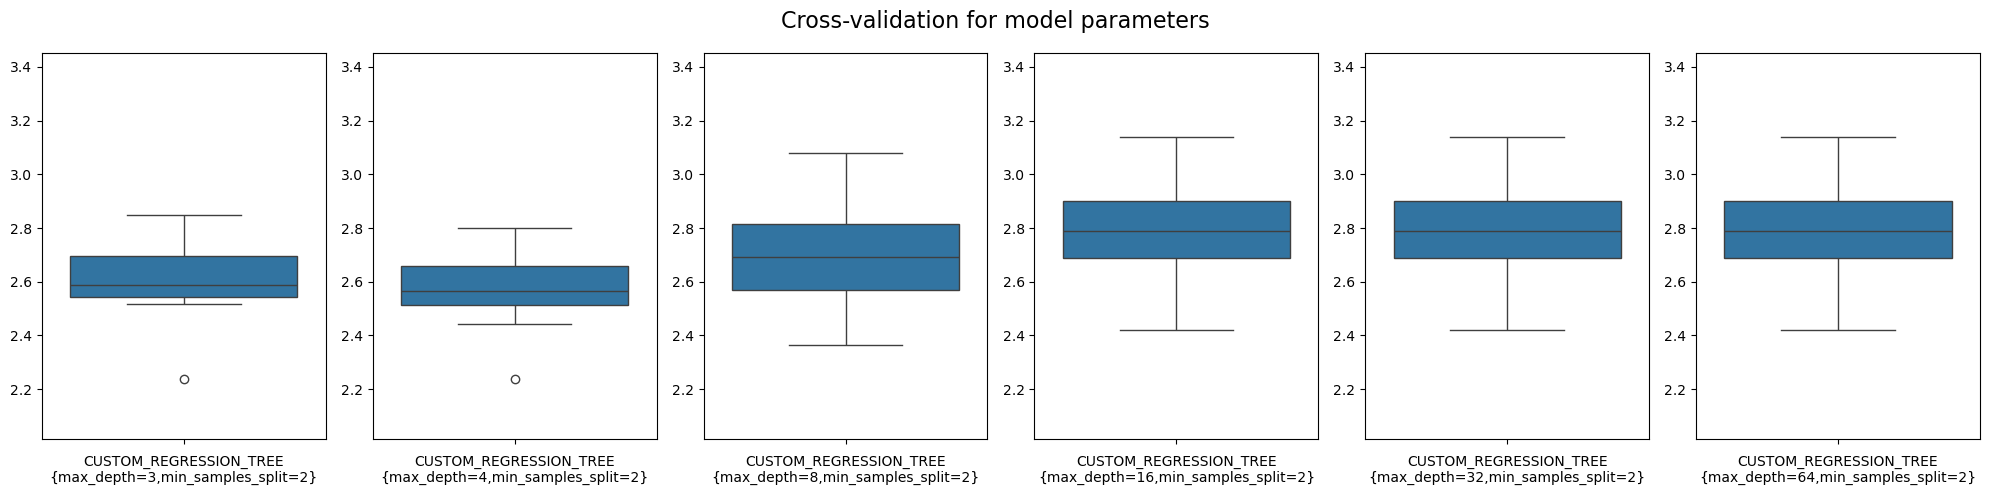

In [59]:
generate_cv_summary(model_scores=model_scores, metric="RMSE")
generate_cv_summary(model_scores=model_scores, metric="MAPE")